In [1]:
import numpy as np 
from numpy import inf
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

# Все написанные функции лежат здесь
from model_functions import *

# Для автообновления конфига
%load_ext autoreload
%autoreload 2

## 1. Подготовка

### Данные

In [19]:
data=pd.read_excel('data_itog.xlsx',sheet_name='short_list')
data=data.dropna()

### Признаки

In [20]:
# Темпы роста
data_growth=gen_growth(data,data.drop(['period','target'],axis=1).columns)
# Лаги
data_lag_1_all=gen_lag(data,data.drop(['period','target'],axis=1).columns,1)
data_lag_1_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,1)
data_lag_2_all=gen_lag(data,data.drop(['period','target'],axis=1).columns,2)
data_lag_2_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,2)
# Объединяем
features=data_growth.merge(data_lag_1_all,on='period'). \
                          merge(data_lag_1_growth,on='period'). \
                          merge(data_lag_2_all,on='period'). \
                          merge(data_lag_2_growth,on='period')
# Удаляем пропуски
# data_model=data_model.dropna()
print(f'Число наблюдений: {len(features)}')
print(f'Начальный период: {features["period"].min()}')
print(f'Конечный период: {features["period"].max()}')

Число наблюдений: 47
Начальный период: 2010-10-01 00:00:00
Конечный период: 2022-04-01 00:00:00


### Варианты целевой переменной

In [21]:
# Вариант 1. Исходный таргет
data_model_target=features.merge(data[['period','target']],on='period')
# Вариант 2. Темпы прироста
target_growth=gen_growth(data,['target'])
data_model_delta=features.merge(target_growth[['period','delta_rate_target']],on='period')
data_model_delta.rename({'delta_rate_target': 'target'},inplace=True,axis=1)
# Вариант 3. Первые разности темпов прироста
diff_delta=pd.DataFrame({'period':data.period[2:], 
                          'target':target_growth['delta_rate_target'][1:].values-target_growth['delta_rate_target'][:-1].values })
data_model_diff_delta=features.merge(diff_delta[['period','target']],on='period')

In [89]:
data_model_diff_delta

,period,abs_growth_brent_price,index_brent_price,delta_rate_brent_price,abs_growth_unempl_rate,index_unempl_rate,delta_rate_unempl_rate,abs_growth_gdp_volume,index_gdp_volume,delta_rate_gdp_volume,abs_growth_money_m2,index_money_m2,delta_rate_money_m2,l1_brent_price,l1_unempl_rate,l1_gdp_volume,l1_money_m2,l1_abs_growth_brent_price,l1_index_brent_price,l1_delta_rate_brent_price,l1_abs_growth_unempl_rate,l1_index_unempl_rate,l1_delta_rate_unempl_rate,l1_abs_growth_gdp_volume,l1_index_gdp_volume,l1_delta_rate_gdp_volume,l1_abs_growth_money_m2,l1_index_money_m2,l1_delta_rate_money_m2,l2_brent_price,l2_unempl_rate,l2_gdp_volume,l2_money_m2,l2_abs_growth_brent_price,l2_index_brent_price,l2_delta_rate_brent_price,l2_abs_growth_unempl_rate,l2_index_unempl_rate,l2_delta_rate_unempl_rate,l2_abs_growth_gdp_volume,l2_index_gdp_volume,l2_delta_rate_gdp_volume,l2_abs_growth_money_m2,l2_index_money_m2,l2_delta_rate_money_m2,target
0,2010-10-01,4.97,1.063571,6.357125,0.0,1.000000,0.000000,1162.819753,1.096208,9.620843,769.6,1.044408,4.440828,78.18,6.7,12086.463959,17330.1,-9.26,0.894099,-10.590119,-0.6,0.917808,-8.219178,1109.428698,1.101068,10.106815,895.1,1.054463,5.446304,87.44,7.3,10977.035261,16435.0,15.98,1.223622,22.362161,-1.4,0.839080,-16.091954,981.277002,1.098169,9.816934,1104.0,1.072011,7.201096,1.403212
1,2011-01-01,17.86,1.214793,21.479254,0.7,1.104478,10.447761,-224.484172,0.983057,-1.694312,1208.0,1.066741,6.674144,83.15,6.7,13249.283711,18099.7,4.97,1.063571,6.357125,0.0,1.000000,0.000000,1162.819753,1.096208,9.620843,769.6,1.044408,4.440828,78.18,6.7,12086.463959,17330.1,-9.26,0.894099,-10.590119,-0.6,0.917808,-8.219178,1109.428698,1.101068,10.106815,895.1,1.054463,5.446304,-0.251312
2,2011-04-01,24.88,1.246312,24.631225,-1.0,0.864865,-13.513514,1410.022767,1.108257,10.825677,713.1,1.036933,3.693345,101.01,7.4,13024.799539,19307.7,17.86,1.214793,21.479254,0.7,1.104478,10.447761,-224.484172,0.983057,-1.694312,1208.0,1.066741,6.674144,83.15,6.7,13249.283711,18099.7,4.97,1.063571,6.357125,0.0,1.000000,0.000000,1162.819753,1.096208,9.620843,769.6,1.044408,4.440828,-0.756625
3,2011-07-01,-9.15,0.927317,-7.268250,-0.3,0.953125,-4.687500,1310.761261,1.090806,9.080550,807.3,1.040323,4.032306,125.89,6.4,14434.822306,20020.8,24.88,1.246312,24.631225,-1.0,0.864865,-13.513514,1410.022767,1.108257,10.825677,713.1,1.036933,3.693345,101.01,7.4,13024.799539,19307.7,17.86,1.214793,21.479254,0.7,1.104478,10.447761,-224.484172,0.983057,-1.694312,1208.0,1.066741,6.674144,3.145999
4,2011-10-01,-7.18,0.938496,-6.150420,0.0,1.000000,0.000000,1163.211860,1.073875,7.387544,538.6,1.025859,2.585930,116.74,6.1,15745.583567,20828.1,-9.15,0.927317,-7.268250,-0.3,0.953125,-4.687500,1310.761261,1.090806,9.080550,807.3,1.040323,4.032306,125.89,6.4,14434.822306,20020.8,24.88,1.246312,24.631225,-1.0,0.864865,-13.513514,1410.022767,1.108257,10.825677,713.1,1.036933,3.693345,1.228672
5,2012-01-01,1.42,1.012961,1.296093,0.2,1.032787,3.278689,-1726.019030,0.897922,-10.207818,1982.4,1.092780,9.277989,109.56,6.1,16908.795427,21366.7,-7.18,0.938496,-6.150420,0.0,1.000000,0.000000,1163.211860,1.073875,7.387544,538.6,1.025859,2.585930,116.74,6.1,15745.583567,20828.1,-9.15,0.927317,-7.268250,-0.3,0.953125,-4.687500,1310.761261,1.090806,9.080550,807.3,1.040323,4.032306,-0.623203
6,2012-04-01,8.49,1.076500,7.650027,-1.0,0.841270,-15.873016,1253.219172,1.082542,8.254216,574.7,1.024613,2.461337,110.98,6.3,15182.776397,23349.1,1.42,1.012961,1.296093,0.2,1.032787,3.278689,-1726.019030,0.897922,-10.207818,1982.4,1.092780,9.277989,109.56,6.1,16908.795427,21366.7,-7.18,0.938496,-6.150420,0.0,1.000000,0.000000,1163.211860,1.073875,7.387544,538.6,1.025859,2.585930,-4.432695
7,2012-07-01,-15.63,0.869172,-13.082782,-0.2,0.962264,-3.773585,1279.792367,1.077865,7.786522,382.5,1.015988,1.598826,119.47,5.3,16435.995569,23923.8,8.49,1.076500,7.650027,-1.0,0.841270,-15.873016,1253.219172,1.082542,8.254216,574.7,1.024613,2.461337,110.98,6.3,15182.776397,23349.1,1.42,1.012961,1.296093,0.2

### Графики

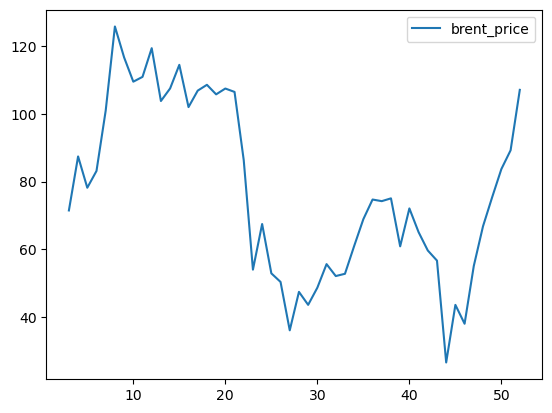

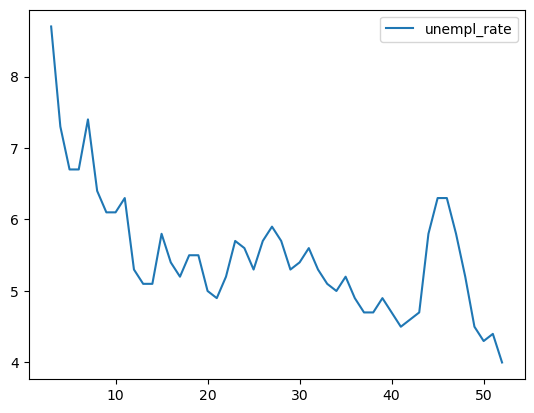

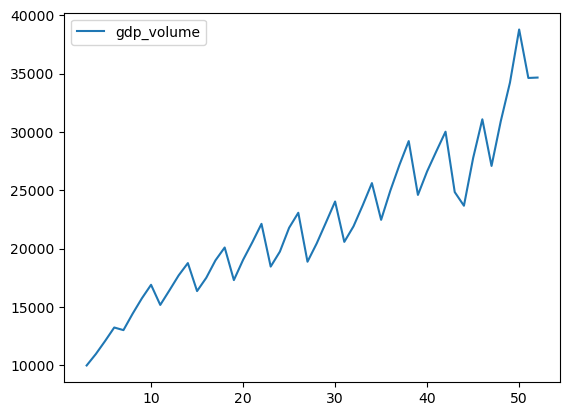

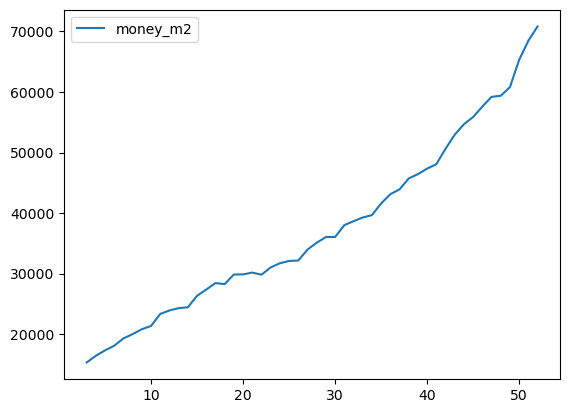

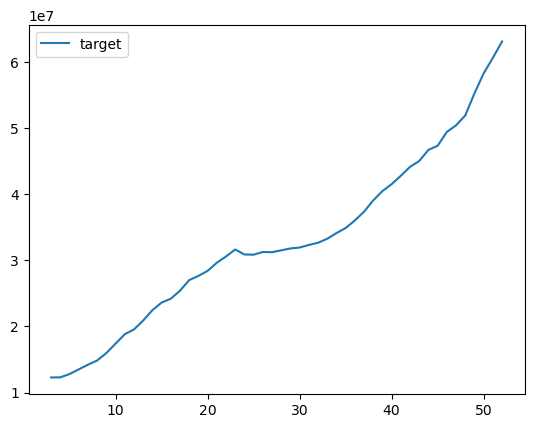

In [36]:
for c in data.drop(['period'],axis=1).columns:
    plt.plot(data[c],label=c)
    plt.legend()
    plt.show()

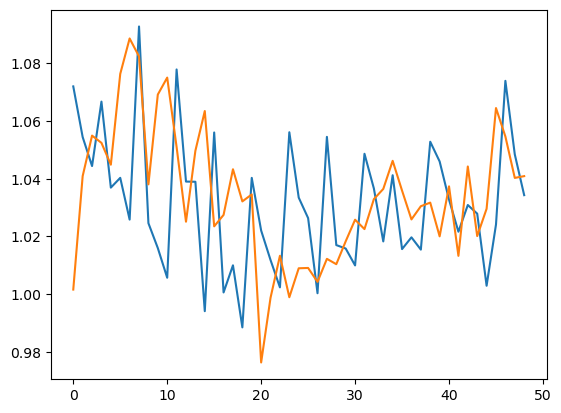

In [51]:
plt.plot(data['money_m2'][1:].values/data['money_m2'][0:-1].values)
plt.plot(data['target'][1:].values/data['target'][0:-1].values)

## 2. Линейная регрессия

### Просто проверка

In [43]:
# X и y
X=data['money_m2'].values.reshape(-1, 1)
y=data['target'].values
# Модель
model=LinearRegression().fit(X,y)
# R2
model.score(X,y)

0.980918834848813

### Train/test

In [69]:
data_train=data[data.period<='2020-12-31']
data_test=data[data.period>='2021-01-01']
X_train,X_test,y_train,y_test=data_train['money_m2'].values.reshape(-1, 1), \
                              data_test['money_m2'].values.reshape(-1, 1), \
                              data_train['target'], \
                              data_test['target']

In [80]:
# Модель
model=LinearRegression().fit(X_train,y_train)
# Прогноз
y_test_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)
# R2
model.score(X_test,y_test)

0.9300520139322295

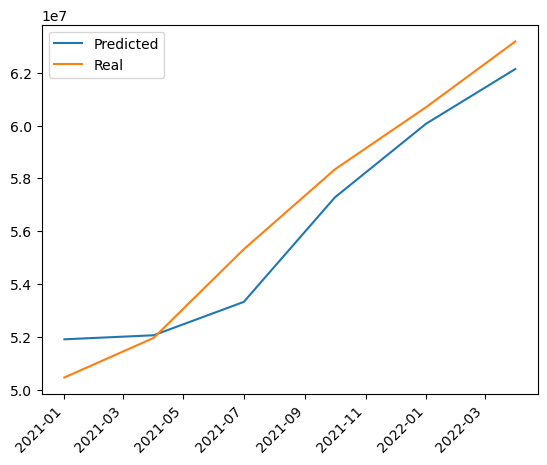

R2 on train: 0.9658
R2 on test: 0.9301
MAPE on train: 0.0647
MAPE on test: 0.0186


In [82]:
plt.plot(data_test['period'],y_test_pred,label='Predicted')
plt.plot(data_test['period'], y_test,label='Real')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()
print(f'R2 on train: {round(r2_score(y_train,y_train_pred),4)}')
print(f'R2 on test: {round(r2_score(y_test,y_test_pred),4)}')
print(f'MAPE on train: {round(mean_absolute_percentage_error(y_train,y_train_pred),4)}')
print(f'MAPE on test: {round(mean_absolute_percentage_error(y_test,y_test_pred),4)}')

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),98.30,-836.81,9.51
MAPE (%),4.42,11.23,1.54


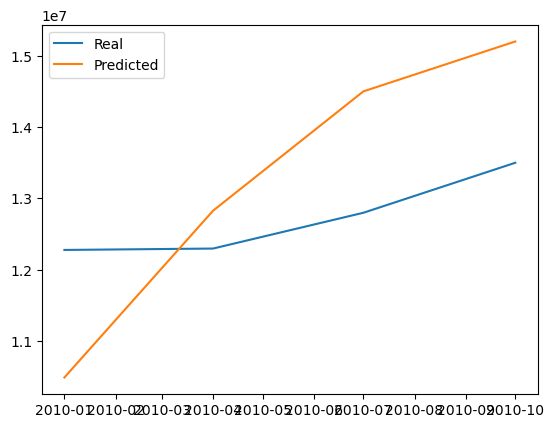

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),98.46,-223.94,3.27
MAPE (%),4.58,13.85,2.02


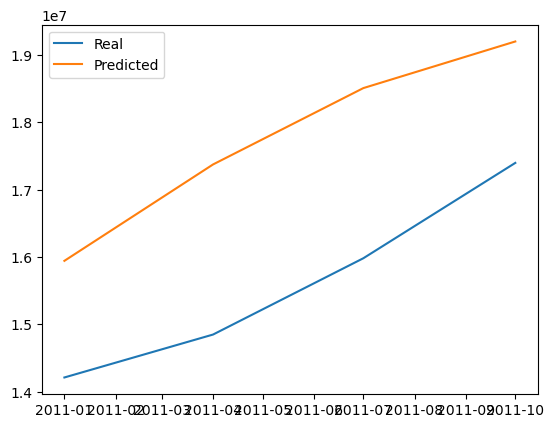

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),98.49,21.88,0.78
MAPE (%),5.04,5.21,0.03


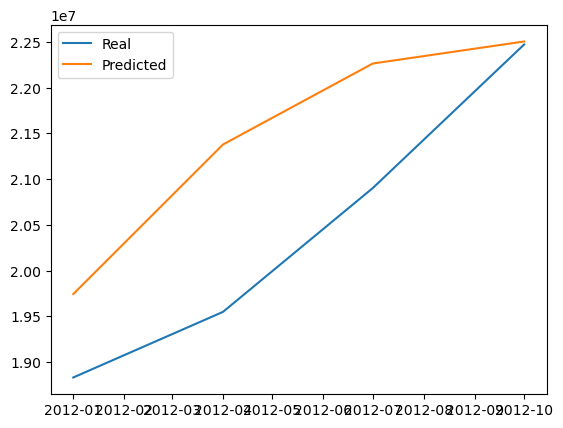

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),98.58,-5.48,1.06
MAPE (%),4.86,4.28,0.12


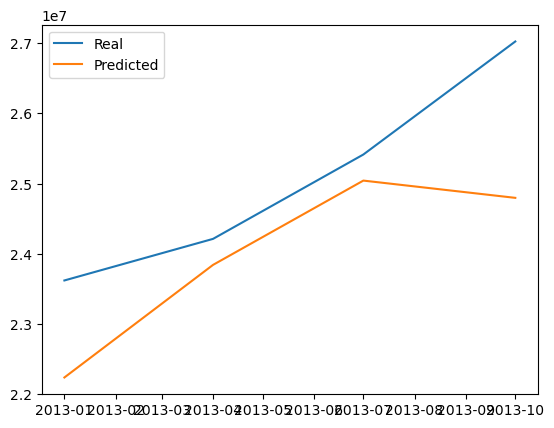

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),98.90,-624.80,7.32
MAPE (%),4.26,10.19,1.39


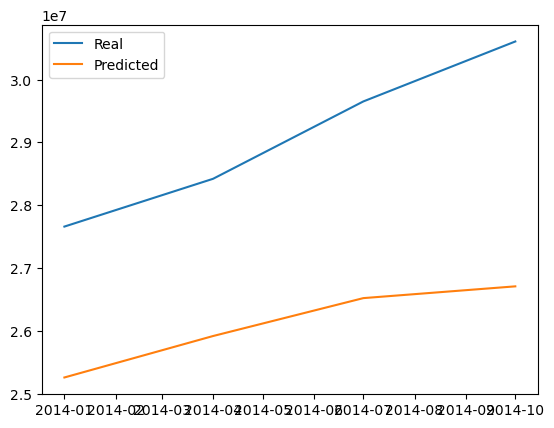

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),99.04,-13010.85,132.37
MAPE (%),4.19,11.33,1.70


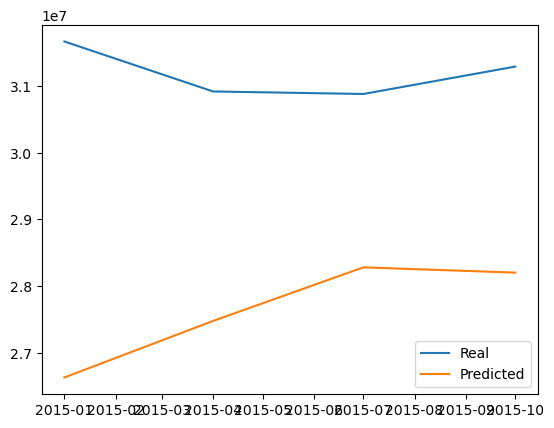

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),98.59,-1240.84,13.59
MAPE (%),5.08,2.79,0.45


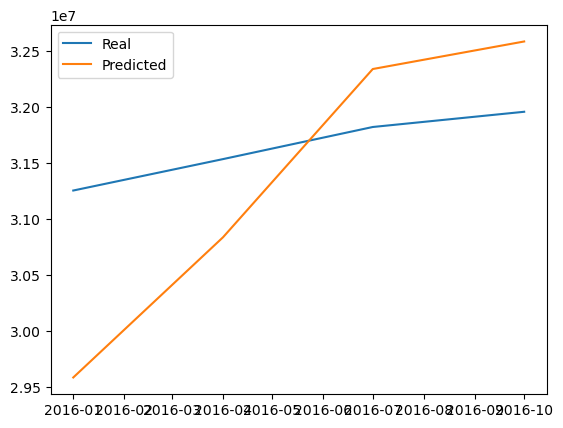

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),98.69,-693.24,8.02
MAPE (%),4.93,5.61,0.14


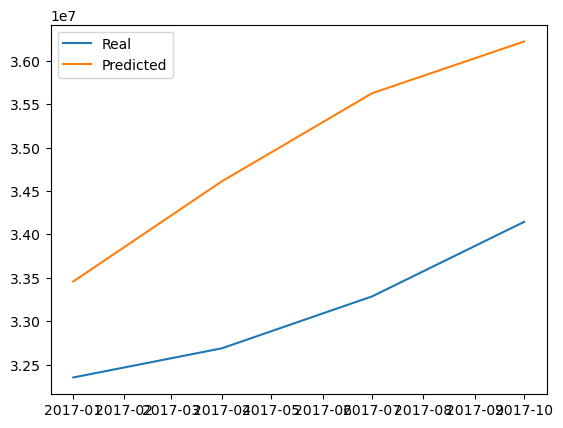

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),98.77,-133.84,2.36
MAPE (%),4.88,6.37,0.31


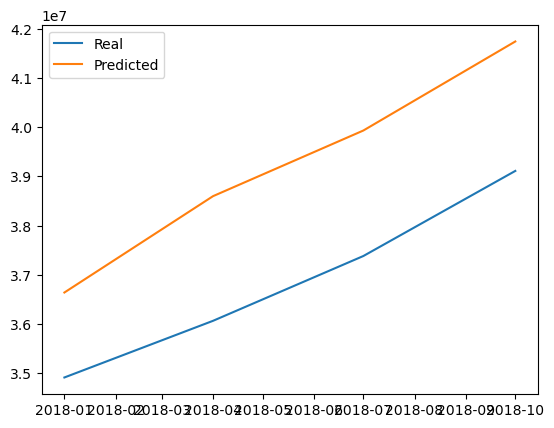

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),98.51,56.95,0.42
MAPE (%),5.17,1.92,0.63


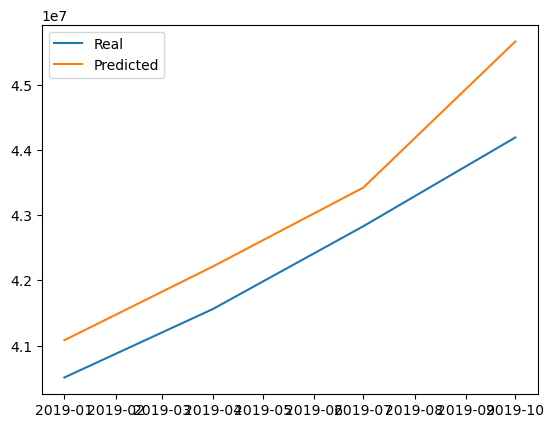

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),98.40,75.35,0.23
MAPE (%),5.26,1.30,0.75


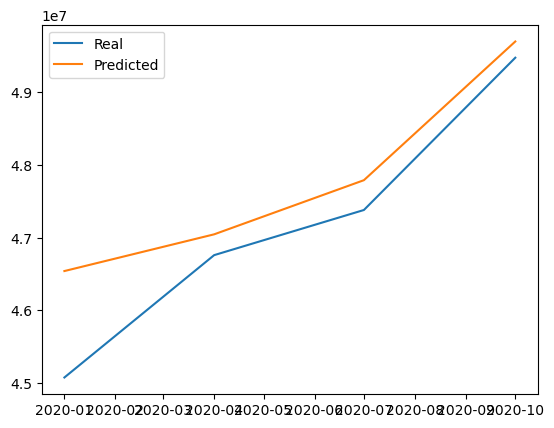

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),98.15,90.67,0.08
MAPE (%),5.25,1.36,0.74


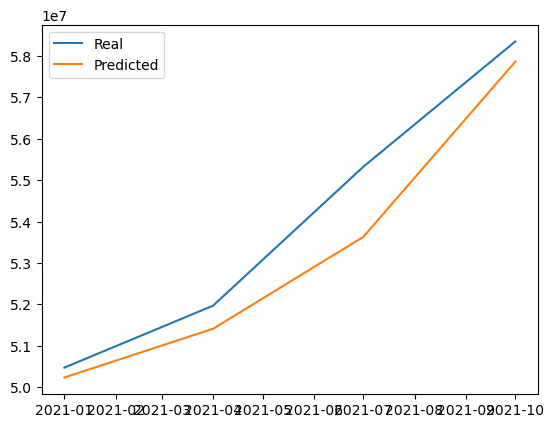

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),98.25,-193.90,2.97
MAPE (%),5.05,3.37,0.33


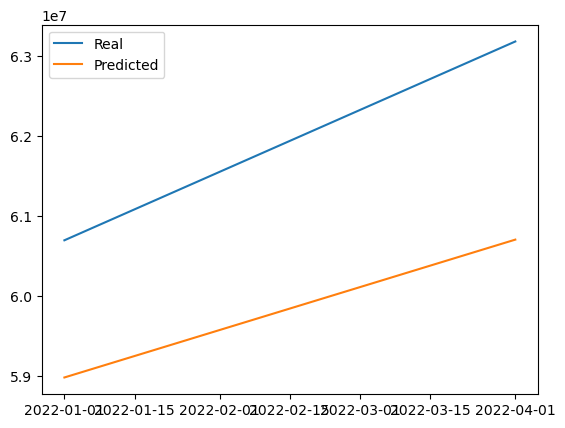

In [88]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data
    ## Выделяем train/test
    data_train=data[(data.period<f'{year}-01-01')|(data.period>=f'{year}-12-31')]
    data_test=data[(data.period>=f'{year}-01-01')&(data.period<f'{year}-12-31')]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,y_test, label='Real')
    plt.plot(data_test.period,y_test_pred, label='Predicted')
    plt.legend()
    plt.show()